In [2]:
%env CUDA_VISIBLE_DEVICES=6
from pathlib import Path
from pprint import pprint

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import seaborn as sns
import torch as ch
import zarr
from torch import Tensor
from tqdm.rich import tqdm, trange

from config import Config

cfg = Config()
# cfg.device="cpu"
pprint(cfg)
encoder_cfg = cfg.encoders[0]
input_path = str(
    Path(cfg.output_dir)
    / encoder_cfg.name
    / encoder_cfg.ood_dataset_name
    / "data.zarr"
)
dataset = zarr.open(input_path)

env: CUDA_VISIBLE_DEVICES=6
Config(device='cuda',
       worker_id=0,
       worker_total=1,
       dry_run=False,
       debug=False,
       output_dir='/raid/pdpl/trak/grads/',
       save_dir='/raid/pdpl/trak/trak_results/',
       write_chunks=1000,
       seed=42,
       proj_dim=2048,
       num_contrastive_samples=50000,
       datasets={'CIFAR100': DatasetConfig(uri='/datasets/cifar100/shards/cifar100-train-{000000..000049}.tar',
                                           uris=None,
                                           size=None,
                                           num_workers=16,
                                           splittable=True,
                                           custom=True),
                 'Food101': DatasetConfig(uri='/datasets/food101/shards/food101-train-{000000..000075}.tar',
                                          uris=None,
                                          size=None,
                                          num_workers=16,
 

In [3]:
uids_ood = np.char.add(
    np.vectorize(lambda x: f"{x:016x}")(dataset.uid["f0"]),
    np.vectorize(lambda x: f"{x:016x}")(dataset.uid["f1"]),
)

In [4]:
g_ood = zarr.load(input_path + "/grads")

In [5]:
out_to_loss_ood = zarr.load(input_path + "/loss_grads")

In [6]:
# Create a structured array combining both arrays
dtype = [
    ("uids", uids_ood.dtype),
    ("grads", g_ood.dtype, g_ood.shape[1]),
    (
        "loss_grads",
        out_to_loss_ood.dtype,
    ),
]
combined = np.empty(len(uids_ood), dtype=dtype)
combined["uids"] = uids_ood
combined["grads"] = g_ood
combined["loss_grads"] = out_to_loss_ood

# Sort in-place based on uids
combined.sort(order="uids")

# Extract back the sorted arrays
uids_ood = combined["uids"]
g_ood_pt = ch.tensor(combined["grads"], device="cpu").pin_memory()
out_to_loss_ood_pt = ch.tensor(
    combined["loss_grads"], device="cpu"
).pin_memory()

In [7]:
def get_xtx(grads: Tensor, batch_size=20_000) -> Tensor:
    proj_dim = grads.shape[1]
    result = ch.zeros(proj_dim, proj_dim, dtype=grads.dtype, device="cuda")
    blocks = ch.split(grads, split_size_or_sections=batch_size, dim=0)

    for block in tqdm(blocks):
        result += block.T.to("cuda") @ block.to("cuda")

    return result

In [8]:
def get_x_xtx_inv(
    grads: Tensor, xtx: Tensor, lambda_reg=0.0, batch_size=20_000
) -> Tensor:
    xtx_reg = xtx + lambda_reg * ch.eye(
        xtx.size(dim=0), device=xtx.device, dtype=xtx.dtype
    )
    xtx_inv = ch.linalg.inv(xtx_reg.to(ch.float32))

    # center X^TX inverse a bit to avoid numerical issues when going to float16
    xtx_inv /= xtx_inv.abs().mean()
    xtx_inv = xtx_inv.to(grads.dtype)

    grads_blocks = ch.split(grads, split_size_or_sections=batch_size, dim=0)

    # Move xtx_inv to GPU once before the loop
    xtx_inv_gpu = xtx_inv.cuda()

    # Process blocks on GPU
    result_blocks = []
    for block in tqdm(grads_blocks, desc="Processing blocks"):
        # Move block to GPU, compute, then back to CPU
        block_gpu = block.cuda()
        result_gpu = block_gpu @ xtx_inv_gpu
        result_blocks.append(result_gpu.cpu())

    # Concatenate results on CPU
    result = ch.cat(result_blocks)

    return result.to(dtype=grads.dtype)

In [25]:
all_ood_scores = {}
all_id_scores = {}

In [10]:
def get_indices(target, id: bool = True):
    id_indices_zarr = zarr.open("/raid/pdpl/id_downstream_idx.zarr", mode="r")
    if id:
        return id_indices_zarr[target]["id_indices"]
    else:
        return id_indices_zarr[target]["downstream_indices"]

In [33]:
scores_zarr = zarr.open(
    "/datasets/datacomp/nearest_neighbor_scores.zarr", mode="a"
)
if "trak" not in scores_zarr:
    scores_zarr.create_group("trak")
scores_zarr = scores_zarr["trak"]
# get target features
for target in [
    "fitzpatrick17k",
    "fairvision/dr",
    "fairvision/amd",
    "fairvision/glaucoma",
    "pcam",
    "food101",
    "cifar100",
    "stl10",
]:
    if target in all_ood_scores.keys():
        continue
    if target in scores_zarr:
        all_ood_scores[target] = np.array(scores_zarr[target]["ood_scores"])
        all_id_scores[target] = np.array(scores_zarr[target]["id_scores"])
        continue
    input_path = str(Path(cfg.output_dir) / encoder_cfg.name / target)
    dataset_target = ds.dataset(input_path, format="parquet")
    batch_size = 16384
    scanner = dataset_target.scanner(
        columns=["grads", "uid", "loss_grads"], batch_size=batch_size
    )
    batches = scanner.to_batches()
    grads_list = []
    uids_list = []
    out_to_loss_list = []
    for batch in tqdm(
        scanner.to_batches(),
        total=dataset_target.count_rows() // batch_size,
        desc="Loading targetbatches",
    ):
        grads_list.extend(batch.column("grads").to_numpy(zero_copy_only=False))
        uids_list.extend(batch.column("uid").to_numpy(zero_copy_only=False))
        out_to_loss_list.extend(
            batch.column("loss_grads").to_numpy(zero_copy_only=False)
        )
    g_target = np.stack(grads_list)
    uids_target = np.stack(uids_list)
    out_to_loss = np.stack(out_to_loss_list)
    dtype = [
        ("uids", uids_target.dtype),
        ("grads", g_target.dtype, g_target.shape[1]),
        ("out_to_loss", out_to_loss.dtype),
    ]
    combined = np.empty(len(uids_target), dtype=dtype)
    combined["uids"] = uids_target
    combined["grads"] = g_target
    combined["out_to_loss"] = out_to_loss
    combined.sort(order="uids")
    downstream_indices = get_indices(
        target, id=False
    )  # get downstream indices
    g_target = combined["grads"][downstream_indices]
    g_target_pt = ch.tensor(g_target, device="cpu").pin_memory()
    id_indices = get_indices(target, id=True)
    g_id = combined["grads"][id_indices]
    g_id_pt = ch.tensor(g_id, device="cpu").pin_memory()
    out_to_loss_id = combined["out_to_loss"][id_indices]
    out_to_loss_id_pt = ch.tensor(out_to_loss_id, device="cpu").pin_memory()

    g_all = ch.cat([g_id_pt, g_ood_pt])
    out_to_loss_all = ch.cat([out_to_loss_id_pt, out_to_loss_ood_pt])

    xtx = get_xtx(g_all)
    x_xtx_inv = get_x_xtx_inv(g_all, xtx)
    features_pt = x_xtx_inv.pin_memory()

    batch_size = 8192 * 2
    scores = []
    for i in trange(0, len(features_pt), batch_size, desc="Computing scores"):
        batch = features_pt[i : i + batch_size].cuda()
        batch_scores = ch.mean(batch @ g_target_pt.cuda().T, axis=1)
        scores.append(batch_scores.cpu())
    scores = ch.cat(scores)
    scores = scores * out_to_loss_all

    scores_ood = scores[len(g_id_pt) :]
    scores_id = scores[: len(g_id_pt)]

    if target not in scores_zarr:
        target_group = scores_zarr.create_group(target)
    else:
        target_group = scores_zarr[target]

    # Save the scores
    target_group.array(
        "id_scores",
        np.array(scores_id.cpu()),
        dtype=np.float32,
        overwrite=True,
    )
    target_group.array(
        "ood_scores",
        np.array(scores_ood.cpu()),
        dtype=np.float32,
        overwrite=True,
    )
    all_ood_scores[target] = scores_ood.cpu()
    all_id_scores[target] = scores_id.cpu()


Output()

/tmp/ipykernel_1655642/1007568943.py:34: TqdmExperimentalWarning: rich is experimental/alpha
  for batch in tqdm(


Output()

/tmp/ipykernel_1655642/1277497041.py:6: TqdmExperimentalWarning: rich is experimental/alpha
  for block in tqdm(blocks):


Output()

/tmp/ipykernel_1655642/1614473132.py:20: TqdmExperimentalWarning: rich is experimental/alpha
  for block in tqdm(grads_blocks, desc="Processing blocks"):


Output()

/git/trak_manual/.venv/lib/python3.11/site-packages/tqdm/rich.py:146: TqdmExperimentalWarning: rich is experimental/alpha
  return tqdm_rich(range(*args), **kwargs)


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [34]:
all_ood_scores.keys()

dict_keys(['fitzpatrick17k', 'fairvision/dr', 'fairvision/amd', 'fairvision/glaucoma', 'pcam', 'food101', 'cifar100', 'stl10'])

In [45]:
data = []
for key in all_ood_scores.keys():
    ood_scores = all_ood_scores[key]
    id_scores = all_id_scores[key]
    
    ood_mean = ood_scores.mean().item()
    ood_std = ood_scores.std().item()
    id_mean = id_scores.mean().item() 
    id_std = id_scores.std().item()
    
    data.append({
        "dataset": key,
        "ood_mean": ood_mean,
        "ood_std": ood_std,
        "id_mean": id_mean,
        "id_std": id_std
    })

df = pd.DataFrame(data)
df = df.sort_values("ood_std", ascending=False)
print(df.to_string(float_format=lambda x: "{:.4f}".format(x)))


               dataset  ood_mean  ood_std  id_mean  id_std
2       fairvision/amd    0.0000   0.0010   0.0447  0.0066
1        fairvision/dr    0.0000   0.0010   0.0413  0.0065
3  fairvision/glaucoma    0.0000   0.0009   0.0343  0.0034
7                stl10    0.0000   0.0008   0.0248  0.0128
0       fitzpatrick17k    0.0000   0.0007   0.0236  0.0073
6             cifar100    0.0000   0.0003   0.0077  0.0027
5              food101    0.0000   0.0003   0.0054  0.0021
4                 pcam    0.0000   0.0001   0.0028  0.0003


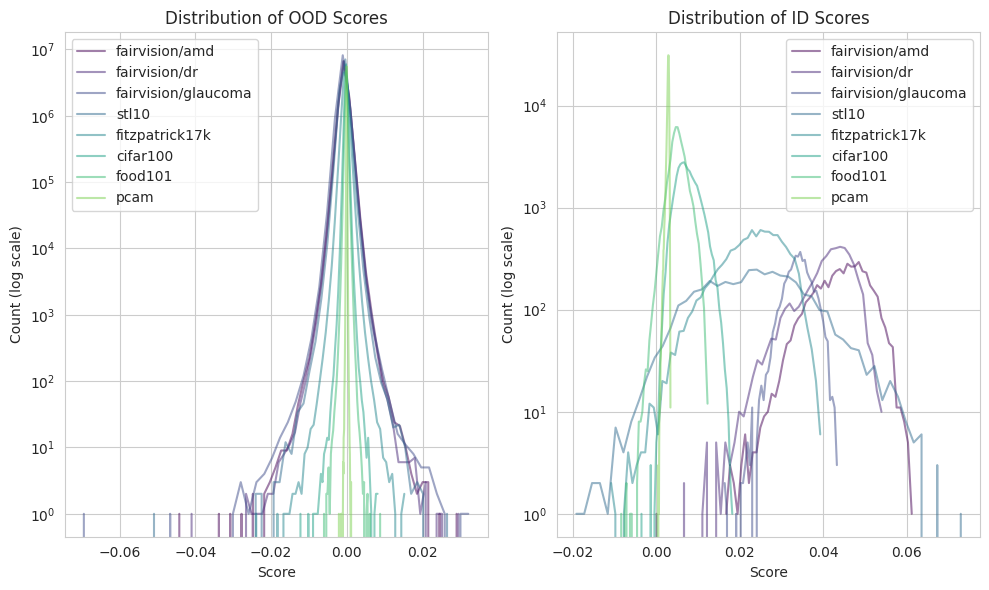

In [40]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid", {"grid.alpha": 0.3})

# Create a continuous color palette with enough colors
num_datasets = len(all_ood_scores)
colors = plt.cm.viridis(np.linspace(0, 0.8, num_datasets))

def compute_histogram(data, bins=50):
    hist, bin_edges = jnp.histogram(data, bins=bins)
    return hist, bin_edges

# Plot OOD scores
plt.subplot(1, 2, 1)
for i, row in enumerate(df.itertuples()):
    key = row.dataset
    scores = all_ood_scores[key]
    scores_np = jnp.array(scores)
    hist, bins = compute_histogram(scores_np)
    
    hist = hist.block_until_ready()
    sns.lineplot(x=bins[:-1], y=hist, alpha=0.5, label=key, color=colors[i])
    plt.yscale("log")

plt.title("Distribution of OOD Scores")
plt.xlabel("Score")
plt.ylabel("Count (log scale)")
plt.legend()

# Plot ID scores
plt.subplot(1, 2, 2)
for i, row in enumerate(df.itertuples()):
    key = row.dataset
    scores = all_id_scores[key]
    scores_np = jnp.array(scores)
    hist, bins = compute_histogram(scores_np)
    
    hist = hist.block_until_ready()
    sns.lineplot(x=bins[:-1], y=hist, alpha=0.5, label=key, color=colors[i])
    plt.yscale("log")

plt.title("Distribution of ID Scores") 
plt.xlabel("Score")
plt.ylabel("Count (log scale)")
plt.legend()

plt.tight_layout()
plt.show()

In [44]:
all_ood_scores['pcam'].min()

tensor(-0.0021)

In [40]:
# from trak.utils import get_matrix_mult_blockwise

# full_scores = get_matrix_mult_blockwise(
#     features, ch.tensor(g_target, device="cpu"), ch.float16, bs=2048
# )
